In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mplhep
import uncertainties as unc
plt.style.use('belle2')
#%jsroot on

%run functins.ipynb

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0eepip4Streams.root"
file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip200000.root"


In [3]:
# Define q2reg_value
q2reg_value = 1  # or any other value you want to use

if q2reg_value in [1, 2, 3, 4]:
    (mc_ele_signal,mc_ele_only_signal,mc_ele_scf,mc_ele_bkg, mc_ele_Continuum_bkg, mc_ele_Bmeson_bkg, 
     mc_ele_signal_weight,mc_ele_only_signal_weight,mc_ele_scf_weight,mc_ele_bkg_weight, mc_ele_Continuum_bkg_weight, mc_ele_Bmeson_bkg_weight) = process_MC_data_combined(file_signal, file_bkg, q2reg_value, False, "ele")

else:
    print("Error: Invalid q2reg_value")


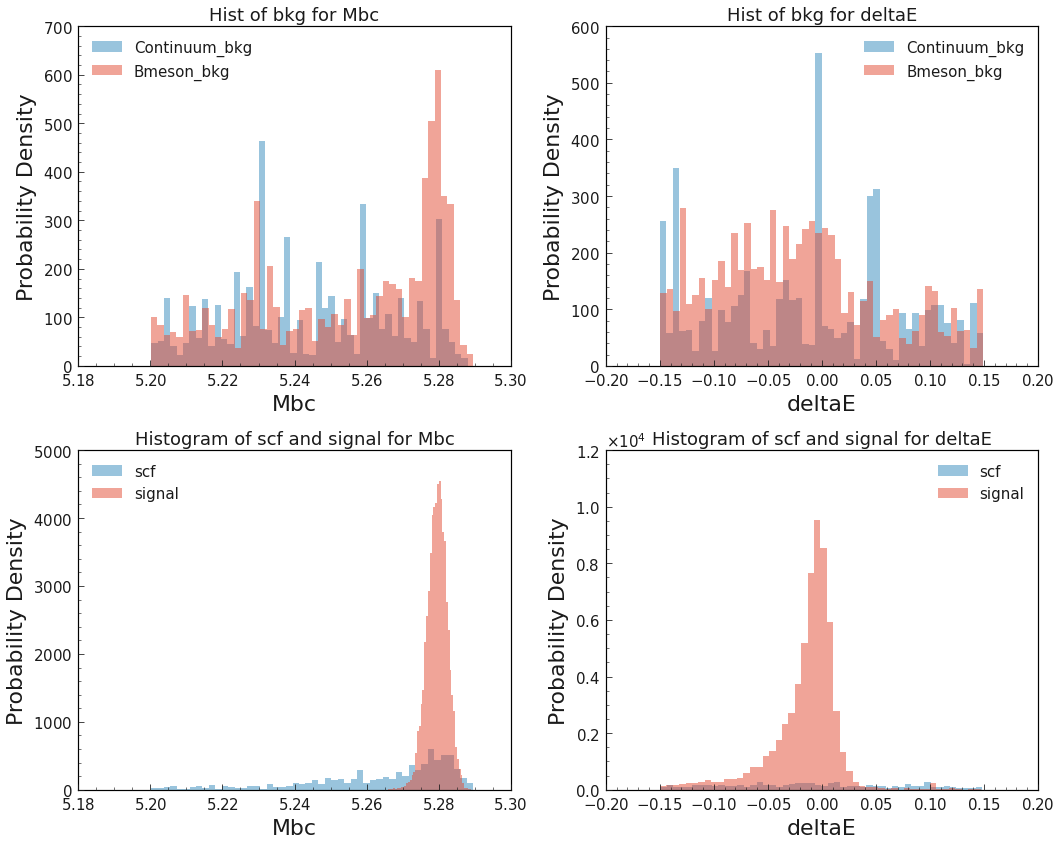

In [4]:

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0],50, {"Continuum_bkg":  mc_ele_Continuum_bkg["Mbc"],
                           "Bmeson_bkg":  mc_ele_Bmeson_bkg["Mbc"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_ele_Continuum_bkg_weight, "Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1],50, {"Continuum_bkg": mc_ele_Continuum_bkg["deltaE"],
                           "Bmeson_bkg": mc_ele_Bmeson_bkg["deltaE"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_ele_Continuum_bkg_weight, "Bmeson_bkg": mc_ele_Bmeson_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0],50, {"scf": mc_ele_scf["Mbc"], 
                           "signal": mc_ele_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1],50, {"scf": mc_ele_scf["deltaE"], 
                           "signal": mc_ele_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [5]:
obs_Mbc = zfit.Space('Mbc', limits=(5.20, 5.29))
obs_deltaE = zfit.Space('deltaE', limits=(-0.15, 0.15))

## Fixed Fit

In [34]:
def fit_fixed(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type,q2reg):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
        if particle_type == 'ele':
            mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
            mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
        elif particle_type == 'mu':
            mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
            mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
        if particle_type == 'ele':
            mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
            mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
        elif particle_type == 'mu':
            mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
            mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
        
    else:
        raise ValueError(f"Unknown label: {label}")

    r = round(np.random.rand(), 4)
    parameter_df = pd.read_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}_{q2reg}.csv")
    
    
    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=True)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.CrystalBall(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
            alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    elif model_type == 'cb_gauss':

        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)

        label_dataset_name_cb_fixed = zfit.pdf.CrystalBall(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
            alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", parameter_df[f"frac_{particle_type}_{label}_{dataset_name}_{model_type}"].values[0], floating=True)  

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb_fixed, label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)



    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",parameter_df[f"frac_{particle_type}_{label}_{dataset_name}_{model_type}"].values[0], floating=True)
        
        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed,label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)

    
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",parameter_df[f"frac_{particle_type}_{label}_{dataset_name}_{model_type}"].values[0], floating=True)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus_fixed,label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.28819 )
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
    
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])


  
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", parameter_df[f"frac_{particle_type}_{label}_{dataset_name}_{model_type}"].values[0], floating=True)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed, label_dataset_name_argus_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label
        )
            
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    
    data_label_dataset_name = zfit.data.Data.from_pandas(mc_dataset_name_data_label, obs=obs_label, weights=mc_dataset_name_weight_label)

    
    return label_dataset_name_model_type_fixed

# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',1)
deltaE_only_signal_cb_gauss_fixed = fit_fixed('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',1)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',1)
deltaE_scf_poly_gauss_fixed= fit_fixed('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',1)


#Bmeson_bkg
Mbc_Bmeson_bkg_argus_gauss_fixed= fit_fixed('Mbc','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["Mbc"], mc_ele_Bmeson_bkg_weight,'argus_gauss',1)
deltaE_Bmeson_bkg_poly_gauss_fixed= fit_fixed('deltaE','ele', 'Bmeson_bkg',  mc_ele_Bmeson_bkg["deltaE"], mc_ele_Bmeson_bkg_weight,'poly_gauss',1)


#Continuum_bkg
Mbc_Continuum_bkg_argus_fixed= fit_fixed('Mbc','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["Mbc"], mc_ele_Continuum_bkg_weight,'argus',1)
deltaE_Continuum_bkg_poly_gauss_fixed= fit_fixed('deltaE','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["deltaE"], mc_ele_Continuum_bkg_weight,'poly_gauss',1)


name                           value  (rounded)    at limit
---------------------------  ------------------  ----------
mu_ele_Mbc_signal_cb_0.3491             5.27965       False
True
name                                      value  (rounded)    at limit
--------------------------------------  ------------------  ----------
frac_ele_deltaE_signal_cb_gauss_0.1737            0.915616       False
True
name                                  value  (rounded)    at limit
----------------------------------  ------------------  ----------
frac_ele_Mbc_scf_argus_gauss_0.528            0.719545       False
True
name                                     value  (rounded)    at limit
-------------------------------------  ------------------  ----------
frac_ele_deltaE_scf_poly_gauss_0.5221            0.962406       False
True
name                                          value  (rounded)    at limit
------------------------------------------  ------------------  ----------
frac_ele_Mbc_Bmeson_bkg_ar

No handles with labels found to put in legend.


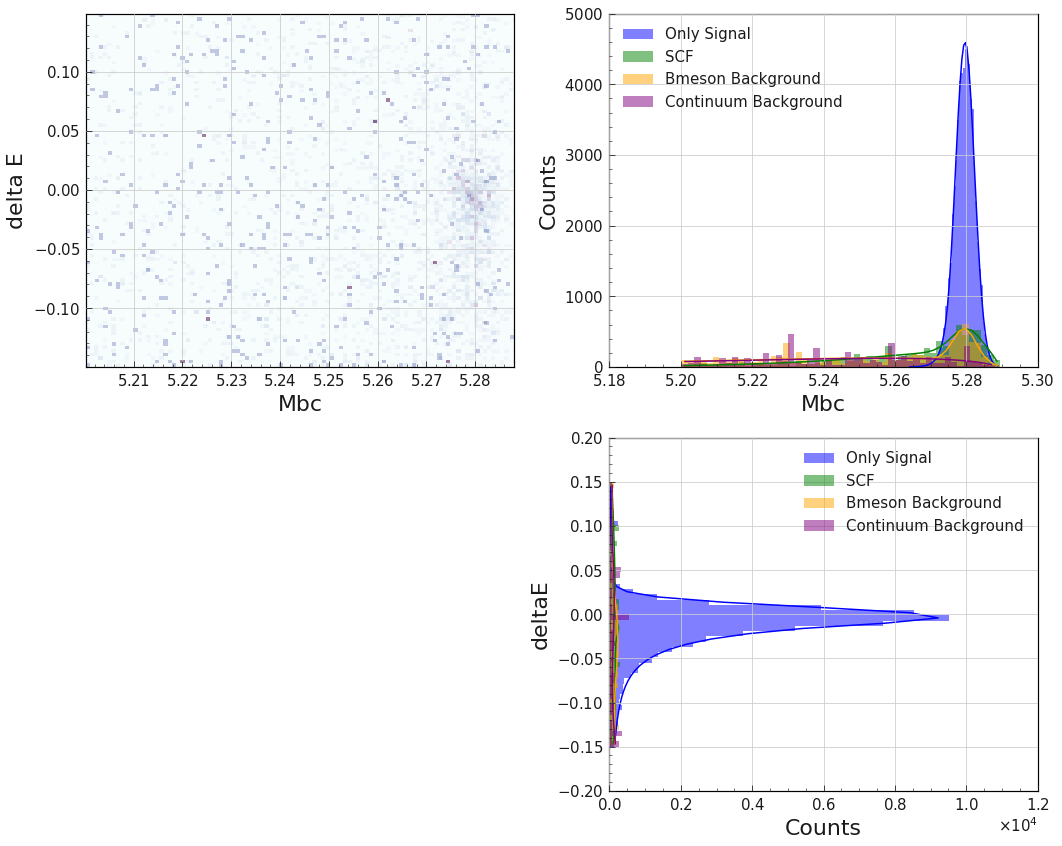

In [35]:
def plots_2D_Mbc_deltaE(Mbc_values_data_list, data_weight_list, deltaE_values_data_list, fit_model_Mbc_list, fit_model_deltaE_list, labels):
    fig = plt.figure(figsize=(15, 12))

    # 2D histogram
    ax_2d = plt.subplot(221)
    for Mbc_values_data_name, deltaE_values_data_name, data_weight, label in zip(Mbc_values_data_list, deltaE_values_data_list, data_weight_list, labels):
        hb = ax_2d.hist2d(Mbc_values_data_name, deltaE_values_data_name, bins=100, cmap='BuPu', alpha=0.5, label=label)
    ax_2d.set_xlabel("Mbc")
    ax_2d.set_ylabel("delta E")
    ax_2d.grid()
    ax_2d.legend()

    # Mbc histogram (projection along x-axis)
    ax_hist_Mbc = plt.subplot(222)
    colors = ['blue', 'green', 'orange', 'purple']
    for Mbc_values_data_name, data_weight, fit_model_Mbc, label, color in zip(Mbc_values_data_list, data_weight_list, fit_model_Mbc_list, labels, colors):
        n, bins, _ = ax_hist_Mbc.hist(Mbc_values_data_name, bins=50, weights=data_weight, alpha=0.5, label=label, color=color)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        summed_n = np.sum(n)
        pdf_values = fit_model_Mbc.pdf(bin_centers) * sum(data_weight) * (bins[1] - bins[0])
        ax_hist_Mbc.plot(bin_centers, pdf_values, color=color)
    ax_hist_Mbc.set_xlabel('Mbc')
    ax_hist_Mbc.set_ylabel('Counts')
    ax_hist_Mbc.grid()
    ax_hist_Mbc.legend()

    # deltaE histogram (projection along y-axis)
    ax_hist_deltaE = plt.subplot(224)
    for deltaE_values_data_name, data_weight, fit_model_deltaE, label, color in zip(deltaE_values_data_list, data_weight_list, fit_model_deltaE_list, labels, colors):
        n, bins, _ = ax_hist_deltaE.hist(deltaE_values_data_name, bins=50, weights=data_weight, orientation='horizontal', alpha=0.5, label=label, color=color)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        summed_n = np.sum(n)
        pdf_values = fit_model_deltaE.pdf(bin_centers) * sum(data_weight) * (bins[1] - bins[0])
        ax_hist_deltaE.plot(pdf_values, bin_centers, color=color)
    ax_hist_deltaE.set_xlabel('Counts')
    ax_hist_deltaE.set_ylabel('deltaE')
    ax_hist_deltaE.grid()
    ax_hist_deltaE.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plots_2D_Mbc_deltaE(
    [mc_ele_only_signal["Mbc"], mc_ele_scf["Mbc"], mc_ele_Bmeson_bkg["Mbc"], mc_ele_Continuum_bkg["Mbc"]],
    [mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, mc_ele_Continuum_bkg_weight],
    [mc_ele_only_signal["deltaE"], mc_ele_scf["deltaE"], mc_ele_Bmeson_bkg["deltaE"], mc_ele_Continuum_bkg["deltaE"]],
    [Mbc_only_signal_cb_fixed, Mbc_scf_argus_gauss_fixed, Mbc_Bmeson_bkg_argus_gauss_fixed, Mbc_Continuum_bkg_argus_fixed],
    [deltaE_only_signal_cb_gauss_fixed, deltaE_scf_poly_gauss_fixed, deltaE_Bmeson_bkg_poly_gauss_fixed, deltaE_Continuum_bkg_poly_gauss_fixed],
    ['Only Signal', 'SCF', 'Bmeson Background', 'Continuum Background']
)



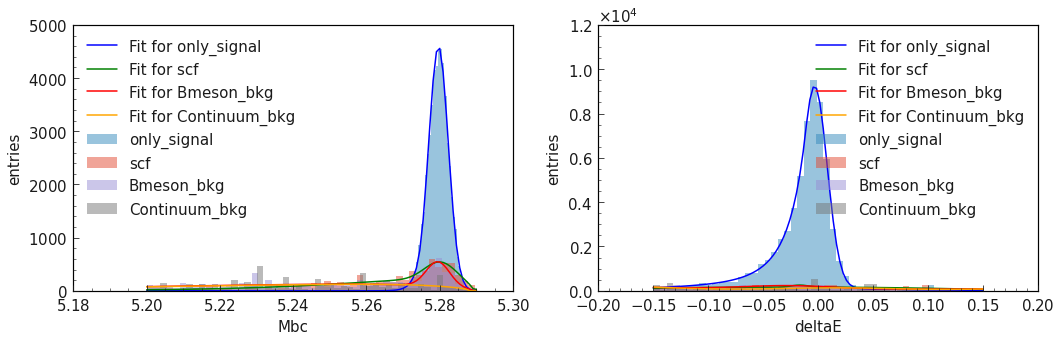

In [36]:
def plot_with_fit(ax, bins, data, data_weight, fitted_model, data_range, label_data, label_fit, xlabel, ylabel, color):
    # Calculate histogram
    n, bins, _ = ax.hist(data, bins=bins, weights=data_weight, density=False, alpha=0.5, label=label_data)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((data >= bins[i]) & (data < bins[i+1]))[0]
        bin_weights.append(data_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # De-normalization
    pdf_values = fitted_model.pdf(data_range).numpy() * sum(data_weight) * (bins[1] - bins[0])

    # Plot histogram with error bars and fitted model
    # ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label=f'{label_data} with Error Bars')
    ax.plot(data_range, pdf_values, color=color, label=label_fit)

    # Add labels and title
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    return pdf_values

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


plot_with_fit(axs[0], 50, mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight, 
              Mbc_only_signal_cb_fixed, Mbc_range, 'only_signal', 'Fit for only_signal', 
              'Mbc', 'entries', color='blue')

plot_with_fit(axs[0], 50, mc_ele_scf["Mbc"], mc_ele_scf_weight, 
              Mbc_scf_argus_gauss_fixed, Mbc_range, 'scf', 'Fit for scf', 
              'Mbc', 'entries', color='green')

plot_with_fit(axs[0], 50, mc_ele_Bmeson_bkg["Mbc"], mc_ele_Bmeson_bkg_weight, 
              Mbc_Bmeson_bkg_argus_gauss_fixed, Mbc_range, 'Bmeson_bkg', 'Fit for Bmeson_bkg', 
              'Mbc', 'entries', color='red')

plot_with_fit(axs[0], 50, mc_ele_Continuum_bkg["Mbc"], mc_ele_Continuum_bkg_weight, 
              Mbc_Continuum_bkg_argus_fixed, Mbc_range, 'Continuum_bkg', 'Fit for Continuum_bkg', 
              'Mbc', 'entries', color='orange')

plot_with_fit(axs[1], 50, mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight, 
              deltaE_only_signal_cb_gauss_fixed, deltaE_range, 'only_signal', 'Fit for only_signal', 
              'deltaE', 'entries', color='blue')

plot_with_fit(axs[1], 50, mc_ele_scf["deltaE"], mc_ele_scf_weight, 
              deltaE_scf_poly_gauss_fixed, deltaE_range, 'scf', 'Fit for scf', 
              'deltaE', 'entries', color='green')

plot_with_fit(axs[1], 50, mc_ele_Bmeson_bkg["deltaE"], mc_ele_Bmeson_bkg_weight,
              deltaE_Bmeson_bkg_poly_gauss_fixed, deltaE_range, 'Bmeson_bkg', 'Fit for Bmeson_bkg', 
              'deltaE', 'entries', color='red')

plot_with_fit(axs[1], 50, mc_ele_Continuum_bkg["deltaE"], mc_ele_Continuum_bkg_weight,
              deltaE_Continuum_bkg_poly_gauss_fixed, deltaE_range, 'Continuum_bkg', 'Fit for Continuum_bkg', 
              'deltaE', 'entries', color='orange')


# Adjust layout
plt.tight_layout()

In [37]:
def fit_extended_model(Mbc_only_signal_pdf,Mbc_scf_pdf, deltaE_only_signal_pdf,deltaE_scf_pdf, Mbc_Bmeson_bkg_pdf,Mbc_Continuum_bkg_pdf, deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf, data, weights):
    
    obs_Mbc = zfit.Space('Mbc', limits=(5.20, 5.29))
    obs_deltaE = zfit.Space('deltaE', limits=(-0.15, 0.15))
    
    combined_obs = obs_Mbc*obs_deltaE
    
    # Random number for parameter names
    r = np.round(np.random.rand(), decimals=4)
    
    # Signal model
    

    Mbc_signal_pdf = Mbc_only_signal_pdf
    deltaE_signal_pdf = deltaE_only_signal_pdf
    
    signal_product_pdf = zfit.pdf.ProductPDF([Mbc_signal_pdf, deltaE_signal_pdf])
    signal_yield = zfit.Parameter(f"signal_yield_{r}", 10000)
    signal_extended = signal_product_pdf.create_extended(signal_yield)

    # Background model
    frac_Mbc_bkg1 = zfit.Parameter(f'frac_Mbc_bkg1_{r}', 0.5)
    frac_deltaE_bkg1 = zfit.Parameter(f'frac_deltaE_bkg1_{r}', 0.5)
    frac_Mbc_bkg2 = zfit.Parameter(f'frac_Mbc_bkg2_{r}', 0.5)
    frac_deltaE_bkg2 = zfit.Parameter(f'frac_deltaE_bkg2_{r}',0.5)
    
    Mbc_background_pdf = zfit.pdf.SumPDF([Mbc_scf_pdf,Mbc_Bmeson_bkg_pdf, Mbc_Continuum_bkg_pdf], fracs=[frac_Mbc_bkg1,frac_Mbc_bkg2])
    deltaE_background_pdf = zfit.pdf.SumPDF([deltaE_scf_pdf,deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf], fracs=[frac_deltaE_bkg1,frac_deltaE_bkg2])

    background_product_pdf = zfit.pdf.ProductPDF([Mbc_background_pdf, deltaE_background_pdf])
    background_yield = zfit.Parameter(f"background_yield_{r}", 1000)
    background_extended = background_product_pdf.create_extended(background_yield)

    # Total model sum
    total_model = zfit.pdf.SumPDF([signal_extended, background_extended])
    
    # Create a joint data for Mbc and deltaE
    combined_data = zfit.data.Data.from_pandas(data, obs=combined_obs, weights=weights)

    # Create an extended NLL for the model and data
    nll = zfit.loss.ExtendedUnbinnedNLL(model=total_model, data=combined_data)

    # Minimize the NLL
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    return Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result


Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_Bmeson_bkg["Mbc"],mc_ele_Continuum_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_Bmeson_bkg["deltaE"],mc_ele_Continuum_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_only_signal_cb_fixed, Mbc_scf_argus_gauss_fixed, deltaE_only_signal_cb_gauss_fixed, deltaE_scf_poly_gauss_fixed,
    Mbc_Bmeson_bkg_argus_gauss_fixed,Mbc_Continuum_bkg_argus_fixed,  deltaE_Bmeson_bkg_poly_gauss_fixed,deltaE_Continuum_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight])
)

#result.hesse(name='hesse')
#result.errors()
print(result.params)
print(result.valid)

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(


name                                               value  (rounded)    at limit
-----------------------------------------------  ------------------  ----------
signal_yield_0.8456                                         62985.4       False
background_yield_0.8456                                     18355.4       False
mu_ele_Mbc_signal_cb_0.3491                                 5.27967       False
frac_ele_deltaE_signal_cb_gauss_0.1737                     0.942662       False
frac_Mbc_bkg1_0.8456                                       0.538829       False
frac_Mbc_bkg2_0.8456                                        1.13209       False
frac_ele_Mbc_scf_argus_gauss_0.528                         0.633926       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.6941                  1.08879       False
m_ele_Mbc_Continuum_bkg_argus_0.0523                        5.28295       False
frac_deltaE_bkg1_0.8456                                    0.779092       False
frac_deltaE_bkg2_0.8456                 

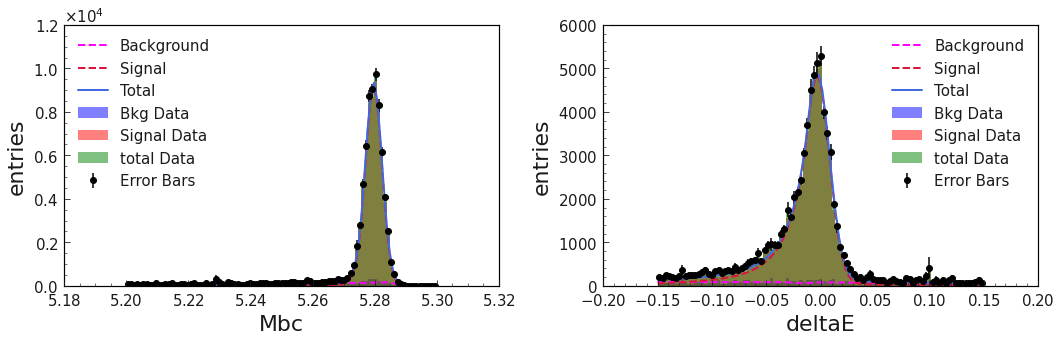

In [38]:
def plot_variable(ax, variable, data_only_signal, data_scf, data_background, weight_only_signal, weight_scf, weight_background, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable],data_scf[variable]])
    bkg_df = data_background[variable]
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = pd.concat([weight_only_signal, weight_scf])
    bkg_weight =weight_background
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.30, 100)
        x_fit = np.linspace(5.20, 5.30, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.5, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(weight_background) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="Magenta", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red', alpha=0.5, label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(weight_only_signal) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green', alpha=0.5, label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('entries')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('q2regs_1 for electron.png')
plt.show()


In [15]:
for 0.1,0.1,0.1,0.1,
name                                               value  (rounded)    at limit
-----------------------------------------------  ------------------  ----------
signal_yield_0.0031                                         16442.7       False
background_yield_0.0031                                     1788.28       False
mu_ele_Mbc_signal_cb_0.9849                                 5.27967       False
frac_ele_deltaE_signal_cb_gauss_0.5311                     0.891475       False
frac_Mbc_bkg1_0.0031                                      0.0500193       False
frac_Mbc_bkg2_0.0031                                      -0.340655       False
frac_ele_Mbc_scf_argus_gauss_0.0314                         1.74205       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.1898                  2.17082       False
m_ele_Mbc_Continuum_bkg_argus_0.8422                        5.28793       False
frac_deltaE_bkg1_0.0031                                   0.0312856       False
frac_deltaE_bkg2_0.0031                                    0.157233       False
frac_ele_deltaE_scf_poly_gauss_0.3626                      0.818964       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.7286                1.05169       False
frac_ele_deltaE_Continuum_bkg_poly_gauss_0.5412           0.0122923       False
False

for 0.2,0.2,0.2,0.2,

name                                               value  (rounded)    at limit
-----------------------------------------------  ------------------  ----------
signal_yield_0.9558                                         67445.5       False
background_yield_0.9558                                     13596.9       False
mu_ele_Mbc_signal_cb_0.5166                                 5.27951       False
frac_ele_deltaE_signal_cb_gauss_0.7581                     0.869805       False
frac_Mbc_bkg1_0.9558                                       0.129257       False
frac_Mbc_bkg2_0.9558                                        2.04854       False
frac_ele_Mbc_scf_argus_gauss_0.1304                        -1.51891       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.4736                  1.23964       False
m_ele_Mbc_Continuum_bkg_argus_0.7425                        5.27278       False
frac_deltaE_bkg1_0.9558                                     0.90186       False
frac_deltaE_bkg2_0.9558                                  -0.0204028       False
frac_ele_deltaE_scf_poly_gauss_0.3156                        1.0005       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.2128               -1.88681       False
frac_ele_deltaE_Continuum_bkg_poly_gauss_0.2814           0.0231703       False
False

for 0.3,0.3,0.3,0.3,

name                                               value  (rounded)    at limit
-----------------------------------------------  ------------------  ----------
signal_yield_0.3056                                           64264       False
background_yield_0.3056                                     17044.1       False
mu_ele_Mbc_signal_cb_0.5104                                 5.27967       False
frac_ele_deltaE_signal_cb_gauss_0.4322                     0.919443       False
frac_Mbc_bkg1_0.3056                                       0.751432       False
frac_Mbc_bkg2_0.3056                                      -0.383341       False
frac_ele_Mbc_scf_argus_gauss_0.0336                        0.497488       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.0144                 0.197394       False
m_ele_Mbc_Continuum_bkg_argus_0.2512                        5.28699       False
frac_deltaE_bkg1_0.3056                                 -0.00654551       False
frac_deltaE_bkg2_0.3056                                    0.966616       False
frac_ele_deltaE_scf_poly_gauss_0.9803                      -0.79867       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.3362               0.971234       False
frac_ele_deltaE_Continuum_bkg_poly_gauss_0.6309          -0.0510273       False
False

for 0.4,0.4,0.4,0.4,
name                                               value  (rounded)    at limit
-----------------------------------------------  ------------------  ----------
signal_yield_0.6809                                         60406.9       False
background_yield_0.6809                                     20889.4       False
mu_ele_Mbc_signal_cb_0.8076                                 5.27971       False
frac_ele_deltaE_signal_cb_gauss_0.6268                     0.990097       False
frac_Mbc_bkg1_0.6809                                   -0.000991859       False
frac_Mbc_bkg2_0.6809                                      0.0216551       False
frac_ele_Mbc_scf_argus_gauss_0.3597                        -118.442       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.1317                 -14.5591       False
m_ele_Mbc_Continuum_bkg_argus_0.6355                         5.2916       False
frac_deltaE_bkg1_0.6809                                     1.00626       False
frac_deltaE_bkg2_0.6809                                  0.00035067       False
frac_ele_deltaE_scf_poly_gauss_0.3349                       1.01627       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.709                -56.1817       False
frac_ele_deltaE_Continuum_bkg_poly_gauss_0.3168           -0.393141       False
False

for 0.5,0.5,0.5,0.5,

name                                               value  (rounded)    at limit
-----------------------------------------------  ------------------  ----------
signal_yield_0.8414                                         62985.4       False
background_yield_0.8414                                     18355.4       False
mu_ele_Mbc_signal_cb_0.9654                                 5.27967       False
frac_ele_deltaE_signal_cb_gauss_0.0987                     0.942662       False
frac_Mbc_bkg1_0.8414                                       0.538829       False
frac_Mbc_bkg2_0.8414                                        1.13209       False
frac_ele_Mbc_scf_argus_gauss_0.8979                        0.633926       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.8233                  1.08879       False
m_ele_Mbc_Continuum_bkg_argus_0.337                         5.28295       False
frac_deltaE_bkg1_0.8414                                    0.779092       False
frac_deltaE_bkg2_0.8414                                    0.210634       False
frac_ele_deltaE_scf_poly_gauss_0.4062                       1.02167       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.9227               0.926458       False
frac_ele_deltaE_Continuum_bkg_poly_gauss_0.7091            0.154125       False
False

SyntaxError: invalid syntax (<ipython-input-15-cf5d7cf9f4bb>, line 1)

In [ ]:
for 0.5,10000,1000,
name                                            value  (rounded)               errors    at limit
--------------------------------------------  ------------------  -------------------  ----------
signal_yield_0.0038                                      57820.3  -5.8e+02   +5.7e+02       False
background_yield_0.0038                                  18439.3  -5.3e+02   +5.5e+02       False
frac_Mbc_signal_0.0038                                   1.03174  - 0.0023   + 0.0022       False
mu_ele_Mbc_signal_cb_0.9308                              5.27972  -1.2e-05   +1.2e-05       False
frac_ele_Mbc_scf_argus_gauss_0.4245                     0.120653  -  0.038   +  0.035       False
frac_deltaE_signal_0.0038                                1.12827  - 0.0084   + 0.0085       False
frac_ele_deltaE_signal_cb_gauss_0.525                   0.916326  - 0.0078   + 0.0081       False
frac_ele_deltaE_scf_poly_gauss_0.1562                   0.864583  -  0.025   +  0.025       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.0452              0.537062  -  0.015   +  0.015       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.2434            0.883053  -  0.015   +  0.015       False
True



for 0.7,20000,1000,
name                                            value  (rounded)               errors    at limit
--------------------------------------------  ------------------  -------------------  ----------
signal_yield_0.2426                                      57808.1  -5.9e+02   +5.7e+02       False
background_yield_0.2426                                  18451.2  -5.3e+02   +5.6e+02       False
frac_Mbc_signal_0.2426                                    1.0318  - 0.0023   + 0.0022       False
mu_ele_Mbc_signal_cb_0.9363                              5.27972  -1.2e-05   +1.2e-05       False
frac_ele_Mbc_scf_argus_gauss_0.6246                     0.121464  -  0.038   +  0.035       False
frac_deltaE_signal_0.2426                                1.12804  - 0.0084   + 0.0085       False
frac_ele_deltaE_signal_cb_gauss_0.4783                  0.916726  - 0.0077   + 0.0081       False
frac_ele_deltaE_scf_poly_gauss_0.0235                   0.863695  -  0.025   +  0.025       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.3384               0.53672  -  0.015   +  0.015       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.7831            0.882713  -  0.015   +  0.015       False
True



In [ ]:
for 0.1:
    name                                            value  (rounded)        hesse    at limit
--------------------------------------------  ------------------  -----------  ----------
signal_yield_0.0719                                      66963.8  +/- 2.6e+02       False
background_yield_0.0719                                   8553.5  +/- 1.7e+03       False
frac_Mbc_signal_0.0719                                  0.754034  +/-    0.04       False
mu_ele_Mbc_signal_gauss_0.1306                           5.27958  +/- 3.7e-05       False
frac_ele_Mbc_scf_argus_gauss_0.4528                     0.825195  +/-  0.0069       False
frac_deltaE_signal_0.0719                               0.801504  +/-   0.014       False
frac_ele_deltaE_signal_cb_gauss_0.8629                  0.881998  +/-  0.0084       False
frac_ele_deltaE_scf_poly_gauss_0.0935                    1.04298  +/-   0.025       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.625               -0.10318  +/- 0.00082       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.1877           -0.688767  +/-   0.045       False
False
    
    
for 0.2:
    name                                            value  (rounded)        hesse    at limit
--------------------------------------------  ------------------  -----------  ----------
signal_yield_0.6569                                      61605.1  +/- 2.5e+03       False
background_yield_0.6569                                  14661.9  +/- 2.5e+03       False
frac_Mbc_signal_0.6569                                  0.997941  +/-  0.0012       False
mu_ele_Mbc_signal_gauss_0.0531                           5.27965  +/- 3.3e-05       False
frac_ele_Mbc_scf_argus_gauss_0.9264                      3.48207  +/-     1.3       False
frac_deltaE_signal_0.6569                                1.09575  +/-   0.031       False
frac_ele_deltaE_signal_cb_gauss_0.1278                  0.896316  +/-    0.03       False
frac_ele_deltaE_scf_poly_gauss_0.2909                   0.820461  +/-   0.092       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.7717              0.656782  +/-     0.1       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.3451            0.975719  +/-   0.083       False
False


for 0.3:
  name                                            value  (rounded)        hesse    at limit
--------------------------------------------  ------------------  -----------  ----------
signal_yield_0.7714                                        58997  +/- 3.5e+03       False
background_yield_0.7714                                  17268.9  +/- 3.5e+03       False
frac_Mbc_signal_0.7714                                   1.04278  +/-    0.01       False
mu_ele_Mbc_signal_gauss_0.2228                           5.27968  +/- 3.5e-05       False
frac_ele_Mbc_scf_argus_gauss_0.495                    -0.0763997  +/-    0.16       False
frac_deltaE_signal_0.7714                                 1.1203  +/-   0.031       False
frac_ele_deltaE_signal_cb_gauss_0.5315                  0.909509  +/-   0.036       False
frac_ele_deltaE_scf_poly_gauss_0.8795                   0.852901  +/-   0.074       False
frac_ele_Mbc_Bmeson_bkg_argus_gauss_0.9861              0.568503  +/-    0.11       False
frac_ele_deltaE_Bmeson_bkg_poly_gauss_0.7632            0.913602  +/-   0.096       False
True  
    

In [39]:
signal_yield_value = result.params[signal_extended.get_yield()]['value']
background_yield_value = result.params[background_extended.get_yield()]['value']

# Round the values
signal_event_fit = round(signal_yield_value, 3)
bkg_event_fit = round(background_yield_value, 3)


mc_ele_signal_weight = pd.concat([mc_ele_only_signal_weight])
mc_ele_bkg_weight = pd.concat([mc_ele_scf_weight,mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight])

mc_ele_signal_MC = round(sum(mc_ele_signal_weight), 3)
mc_ele_bkg_MC = round(sum(mc_ele_bkg_weight), 3)


# Print the results
print("Results from Fit:")
print("Signal Events =", signal_event_fit)
print("Background Events =", bkg_event_fit)
print()

print("Results from MC Data:")
print("Signal Events in MC Data =", mc_ele_signal_MC)
print("Background Events in MC Data =", mc_ele_bkg_MC)
print()

errors_sig_events = mc_ele_signal_MC - signal_event_fit
print("Signal Events different =", round(errors_sig_events, 3))

errors_bkg_events = mc_ele_bkg_MC - bkg_event_fit
print("Background Events different=", round(errors_bkg_events, 3))


Results from Fit:
Signal Events = 62985.445
Background Events = 18355.412

Results from MC Data:
Signal Events in MC Data = 61770.667
Background Events in MC Data = 19526.084

Signal Events different = -1214.778
Background Events different= 1170.672


In [ ]:
import uncertainties as unc
signal_yield =unc.ufloat(526714.918, 37)
signal_event_MC=69125.956


Signal_Events_different= signal_event_MC-signal_yield
print("signal events difference:", Signal_Events_different)


In [ ]:
background_yield =unc.ufloat(49719.979, 51)
background_event_MC=7136.756


background_Events_different= background_event_MC-background_yield
print("background events difference:", background_Events_different)

In [ ]:
def plot_variable(ax, variable, data_only_signal, data_scf, data_background, weight_only_signal, weight_scf, weight_background, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable],data_scf[variable]])
    bkg_df = data_background[variable]
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = pd.concat([weight_only_signal, weight_scf])
    bkg_weight =weight_background
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.30, 100)
        x_fit = np.linspace(5.20, 5.30, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.5, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(weight_background) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="Magenta", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red', alpha=0.5, label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(weight_only_signal) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green', alpha=0.5, label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('entries')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_only_signal, mc_ele_scf, mc_ele_Bmeson_bkg, mc_ele_only_signal_weight, mc_ele_scf_weight, mc_ele_Bmeson_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('q2regs_1 for electron.png')
plt.show()


In [ ]:
def plot_2d_and_projections(axs, x_variable, y_variable, x_data, y_data, weight, x_pdf, y_pdf, label):
    # Define bin edges
    if x_variable == "Mbc":
        x_bin_edges = np.linspace(5.20, 5.30, 100)
    elif x_variable == "deltaE":
        x_bin_edges = np.linspace(-0.15, 0.15, 100)

    if y_variable == "Mbc":
        y_bin_edges = np.linspace(5.20, 5.30, 100)
    elif y_variable == "deltaE":
        y_bin_edges = np.linspace(-0.15, 0.15, 100)

    # Plot 2D histogram
    hist, x_edges, y_edges, _ = axs[0, 0].hist2d(x_data, y_data, bins=[x_bin_edges, y_bin_edges], weights=weight, cmap='viridis')
    axs[0, 0].set_xlabel(x_variable)
    axs[0, 0].set_ylabel(y_variable)
    axs[0, 0].set_title(label)

    # Plot horizontal projection with fit
    x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
    axs[0, 1].hist(x_data, bins=x_bin_edges, weights=weight, color='blue', alpha=0.5, orientation='horizontal')
    y_fit = x_pdf.pdf(x_bin_centers) * np.sum(weight) * np.diff(x_bin_edges)[0]
    axs[0, 1].plot(y_fit, x_bin_centers, label='Fit', linestyle="--", color="magenta", linewidth=2)
    axs[0, 1].set_ylabel(x_variable)
    axs[0, 1].set_title('Horizontal Projection')

    # Plot vertical projection with fit
    y_bin_centers = (y_bin_edges[:-1] + y_bin_edges[1:]) / 2
    axs[1, 0].hist(y_data, bins=y_bin_edges, weights=weight, color='red', alpha=0.5)
    x_fit = y_pdf.pdf(y_bin_centers) * np.sum(weight) * np.diff(y_bin_edges)[0]
    axs[1, 0].plot(y_bin_centers, x_fit, label='Fit', linestyle="--", color="crimson", linewidth=2)
    axs[1, 0].set_xlabel(y_variable)
    axs[1, 0].set_title('Vertical Projection')

    # Add color bar to 2D histogram
    cbar = plt.colorbar(hist, ax=axs[0, 0])
    cbar.set_label('Counts')


#MC data
Signal_Mbc = pd.concat([mc_ele_only_signal["Mbc"], mc_ele_scf["Mbc"]])
Signal_deltaE = pd.concat([mc_ele_only_signal["deltaE"], mc_ele_scf["deltaE"]])

Background_Mbc = mc_ele_Bmeson_bkg["Mbc"]
Background_deltaE = mc_ele_Bmeson_bkg["deltaE"]

df_total_Mbc = pd.concat([Signal_Mbc,Background_Mbc])
df_total_deltaE = pd.concat([Signal_deltaE,Background_deltaE])

#Weight data
Signal_weight = pd.concat([mc_ele_only_signal_weight,mc_ele_scf_weight])
Background_weight = mc_ele_Bmeson_bkg_weight

df_total= pd.concat([Signal_weight,Background_weight])



# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 2D and projections for Mbc and deltaE
plot_2d_and_projections(axs, "Mbc", "deltaE", df_total_Mbc, df_total_deltaE, df_total, Mbc_signal_pdf, deltaE_signal_pdf, "Mbc vs deltaE")

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('2d_and_projections.png')
plt.show()